In [4]:
# !pip install emoji==0.6.0 --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49720 sha256=206ed40c27bde6d728561ef1f7cd59b7b65a6a326aa7f0f0644d50f753144ac3
  Stored in directory: /tmp/pip-ephem-wheel-cache-dursk2ew/wheels/43/3d/82/e7baffa5e86346c6178d7750dba6e8ef063282a37fc563f8f8
Successfully built emoji

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import csv
import pandas as pd
from transformers import BertTokenizerFast, TrainingArguments, Trainer, BertModel, \
    DataCollatorWithPadding, modeling_outputs, MPNetForSequenceClassification, BertForSequenceClassification, \
RobertaForSequenceClassification, AutoModel, AutoTokenizer
from datasets import Dataset, load_dataset, DatasetDict
import csv
import pandas as pd
from sklearn import model_selection
import torch
import evaluate
import numpy as np

In [2]:
with open('Tweets.csv', mode='r') as file:
    df = pd.read_csv(file, header=0)
    df = df.drop(columns=['textID', 'selected_text'], axis=1)
    df = df.rename(columns={"text": "texts", "sentiment": "label"})
    df = df.dropna()

df['label'] = df['label'].replace({"neutral":1, "negative":0, "positive":2})


dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)
# shuffle defaults to true

print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['texts', 'label', '__index_level_0__'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['texts', 'label', '__index_level_0__'],
        num_rows: 5496
    })
})
{'texts': 'Im so full. Subway was bomb! Waiting for my 2nd shift to start', 'label': 2, '__index_level_0__': 22358}


In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def tokenize_function(example):
    """
    Tokenizes input embeddings using model tokenizer"""
    return tokenizer(example["texts"], truncation=True)

metric1 = evaluate.load("precision")
metric2 = evaluate.load("recall")
    
def compute_metrics(eval_preds):
    """
    Computes eval metrics"""
    
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels, average="weighted")
    recall = metric2.compute(predictions=predictions, references=labels, average="weighted")
    

    cm = confusion_matrix(predictions, labels)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return {"precision": precision, "recall": recall}

# tokenize input sequences to subwords
tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
tokenized_tweets = dataset.map(tokenize_function, batched=True)


# for batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/472k [00:00<?, ?B/s]

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5496 [00:00<?, ? examples/s]

In [9]:
# init model: TRYING different base
# takes in a string and pulls the model from huggingface
model =  MPNetForSequenceClassification.from_pretrained("microsoft/mpnet-base", num_labels=3)


# optimizer = transformers.AdamW(lr=0.00002)
# scheduler=transformers.get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=2000, num_training_steps=60000)
args = TrainingArguments(
    output_dir="./results_mpnet_v2",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=40,
    weight_decay=0.01)

# train
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model()

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifie

Step,Training Loss
500,0.606800
1000,0.435200
1500,0.326500
2000,0.242800
2500,0.172200
3000,0.135500
3500,0.099900
4000,0.083900
4500,0.075300
5000,0.058900


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqu

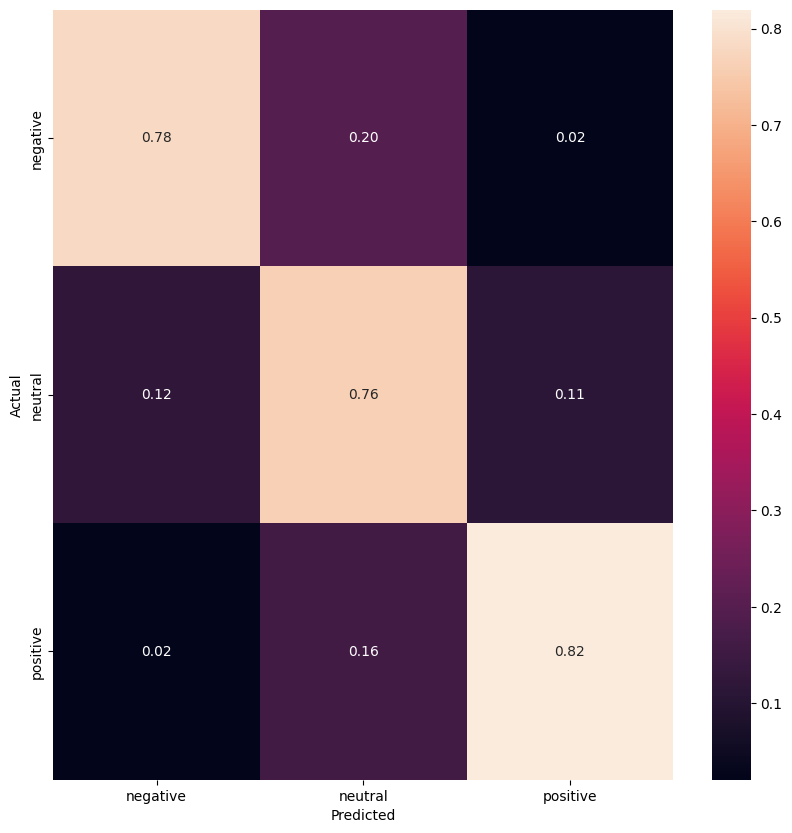

Trainer is attempting to log a value of "{'precision': 0.7850332017841527}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7854803493449781}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.8582662343978882, 'eval_precision': {'precision': 0.7850332017841527}, 'eval_recall': {'recall': 0.7854803493449781}, 'eval_runtime': 19.2347, 'eval_samples_per_second': 285.734, 'eval_steps_per_second': 17.884, 'epoch': 40.0}


In [10]:
with torch.no_grad():
    eval_results = trainer.evaluate(tokenized_tweets["test"])
print(eval_results)

In [6]:
import torch
from torch import nn
print(tokenized_tweets)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())


class CustomModel(nn.Module):
  def __init__(self,model_string,num_labels): 
    super(CustomModel,self).__init__() 
    self.model_string = model_string
    self.num_labels = num_labels 
    self.loss_fct = nn.CrossEntropyLoss()
    
    # load model with given checkpoint and extract its body
    self.model = BertModel.from_pretrained(model_string)
    # freeze bert model
    for param in self.model.parameters():
        param.requires_grad = False
    # build new head
    self.head_stack = nn.Sequential(
        nn.Linear(768*5, 768*5),
        nn.ReLU(),
        nn.Linear(768*5, self.num_labels)
        )


  def forward(self, input_ids=None, attention_mask=None,labels=None):
    # forward pass on base model
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask,return_dict= True, output_hidden_states=True)
    # get hidden states
    encoded_layers = outputs['hidden_states'][-5:]
    # concate per bert paper section 5.3
    concatenated = torch.cat(encoded_layers, -1)
    # get concatenated CLS token
    cls = concatenated[:,0,:] 
    
    # run head model
    logits = self.head_stack(cls)
    
    loss = None
    if labels is not None:
      loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
    return modeling_outputs.SequenceClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

DatasetDict({
    train: Dataset({
        features: ['texts', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['texts', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5496
    })
})
True
cuda
4


In [8]:
# init model: TRYING a dumb idea
# takes in a string and pulls the model from huggingface
model = CustomModel("bert-base-uncased", 3)


args = TrainingArguments(
    output_dir="./results_custom_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01)

# train
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Step,Training Loss
500,0.814600
1000,0.745100
1500,0.728900


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


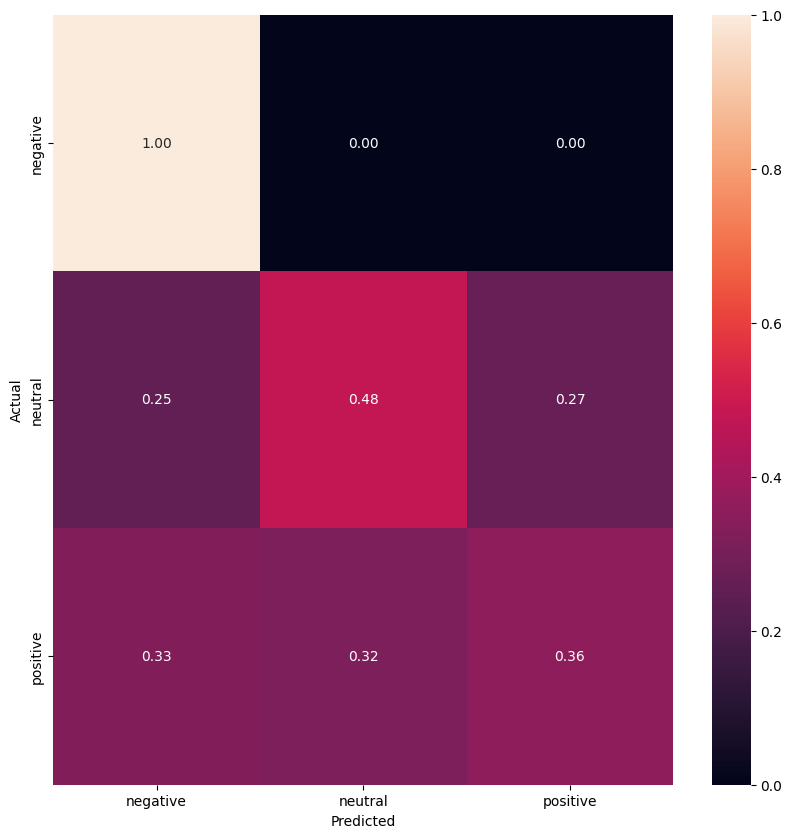

Trainer is attempting to log a value of "{'precision': 0.59154335925049}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.42142369797589263}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.0653905868530273, 'eval_precision': {'precision': 0.59154335925049}, 'eval_recall': {'recall': 0.42142369797589263}, 'eval_runtime': 18.2788, 'eval_samples_per_second': 240.552, 'eval_steps_per_second': 15.045, 'epoch': 3.0}


In [47]:
with torch.no_grad():
    eval_results = trainer.evaluate(tokenized_tweets["test"])
print(eval_results)